**HOMEWORK**  

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```



In [87]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [88]:
#@ DOWNLOADING THE DATASET: UNCOMMENT BELOW:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-10-17 00:42:22--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.4’

housing.csv.4       100%[===================>]   1.36M  --.-KB/s    in 0.1s    

2022-10-17 00:42:22 (11.2 MB/s) - ‘housing.csv.4’ saved [1423529/1423529]



In [89]:
#@ READING DATASET:
PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

- Apply the log transform to `median_house_value`. 
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state parameter` to 1.

In [90]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [91]:
df.median_house_value = np.log1p(df.median_house_value)

In [92]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,13.022766,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,12.789687,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,12.771673,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,12.740520,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,12.743154,NEAR BAY


In [93]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(12384, 4128, 4128)

In [94]:
# getting the target values and deleting them from the dfs
y_train_full = df_train_full.values
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

del(df_train_full['median_house_value'])
del(df_train['median_house_value'])
del(df_val['median_house_value'])
del(df_test['median_house_value'])

In [95]:
y_train

array([12.33754379, 10.91510665, 12.06968575, ..., 12.27373597,
       10.98700312, 12.18127265])

- We will use `DictVectorizer` to turn train and validation into matrices.

In [96]:
#@ IMPLEMENTATION OF DICTVECTORIZER:
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

**Question 1**

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1`.

In [97]:
#@ TRAINING THE REGRESSION MODEL:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=1)

In [98]:
df_train.ocean_proximity.value_counts()

<1H OCEAN     5499
INLAND        3901
NEAR OCEAN    1597
NEAR BAY      1383
ISLAND           4
Name: ocean_proximity, dtype: int64

In [99]:
#@ INSPECTION:
tree_info = export_text(dt, feature_names=dv.feature_names_)
print(tree_info)


|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



- Which feature is used for splitting the data?

- Answer:

ocean_proximity=INLAND

**Question 2**

Train a random forest model with these parameters:

- `n_estimators=10`  
- `random_state=1`  
- `n_jobs=-1` (optional-to make training faster)

In [100]:
#@ TRAINING RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, n_jobs=1, random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)




In [101]:
#@ CALCULATING MEAN SQUARED ERROR:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

0.24579193759466625

- What's the RMSE of this model on validation?

- Answer: 

the answer is 0.25

**Question 3**

Now, let's experiment with the `n_estimators` parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.

In [102]:
#@ TRAINING THE RANDOM FOREST MODEL:
rmses = []

for n in range(10, 201, 10):
    rt = RandomForestRegressor(n_estimators=n, random_state=1)
    rt.fit(X_train, y_train)
    y_pred = rt.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmses.append(rmse)
    print('n_estimators: %s -> %.7f' % (n, rmse))


n_estimators: 10 -> 0.2457919
n_estimators: 20 -> 0.2391505
n_estimators: 30 -> 0.2356507
n_estimators: 40 -> 0.2345425
n_estimators: 50 -> 0.2330541
n_estimators: 60 -> 0.2329153
n_estimators: 70 -> 0.2324990
n_estimators: 80 -> 0.2325668
n_estimators: 90 -> 0.2322198
n_estimators: 100 -> 0.2319435
n_estimators: 110 -> 0.2314839
n_estimators: 120 -> 0.2316022
n_estimators: 130 -> 0.2317046
n_estimators: 140 -> 0.2316817
n_estimators: 150 -> 0.2317125
n_estimators: 160 -> 0.2316734
n_estimators: 170 -> 0.2316090
n_estimators: 180 -> 0.2317810
n_estimators: 190 -> 0.2317879
n_estimators: 200 -> 0.2316625


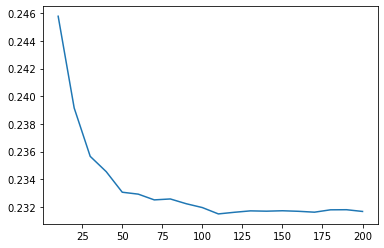

In [103]:
plt.plot(range(10, 201, 10), rmses)
plt.show()

In [104]:
#@ INSPECTING THE RMSE SCORES:


- After which value of `n_estimators` does RMSE stop improving?

- Answer: 

**Question 4**

Let's select the best `max_depth`:

- Try different values of `max_depth`: [10, 15, 20, 25].
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
- Fix the random seed: `random_state=1`.

In [105]:
#@ TRAINING THE MODEL WITH DEPTH:
all_rmses = {}

for m in [10, 15, 20, 25]:
#     print('max_depth: %s' % m)
#     print()
    rmses = []
    
    for n in range(10, 201, 10):
        
        rt = RandomForestRegressor(max_depth=m, n_estimators=n, random_state=1)
        rt.fit(X_train, y_train)
        y_pred = rt.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)
    
    all_rmses[m] = rmses

    

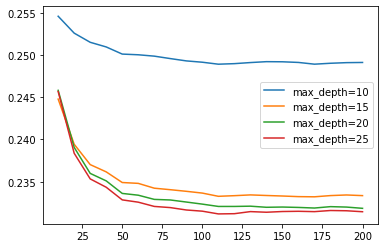

In [106]:
plt.plot(range(10, 201, 10), all_rmses[10], label='max_depth=10')
plt.plot(range(10, 201, 10), all_rmses[15], label='max_depth=15')
plt.plot(range(10, 201, 10), all_rmses[20], label='max_depth=20')
plt.plot(range(10, 201, 10), all_rmses[25], label='max_depth=25')
plt.legend()

plt.show()

- What's the best `max_depth`:

- Answer:

as we can see the best max_depth is 25

In [107]:
all_rmses

{10: [0.25460133019342457,
  0.25259936081647955,
  0.25151411073705776,
  0.2509631937920856,
  0.2501170994722691,
  0.2500355633598958,
  0.2498733909205666,
  0.24958462605555357,
  0.24930989281483018,
  0.24915323220209934,
  0.24891931586008675,
  0.24898414721351048,
  0.24911293867165013,
  0.24921915849407802,
  0.2492048234253767,
  0.24912739463082292,
  0.24892186684591852,
  0.24902960916013372,
  0.24910322070963106,
  0.24912452399131396],
 15: [0.2447823204292666,
  0.2394329332606766,
  0.2370215258057075,
  0.23615993831411072,
  0.23489942801278307,
  0.23479802171481062,
  0.2342269881249864,
  0.23404863310548518,
  0.2338569861863922,
  0.2336464211173285,
  0.23326505825455263,
  0.23333970866155376,
  0.23343125724932448,
  0.2333618445028956,
  0.2332996758811377,
  0.2332269901174181,
  0.23320587960838424,
  0.23335059647895046,
  0.23342345720722768,
  0.23334681003348676],
 20: [0.24582005817841776,
  0.23905822013071992,
  0.2359797551146794,
  0.23509283

**Question 5**

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- `n_estimators=10`,
- `max_depth=20`,
- `random_state=1`,
- `n_jobs=-1` (optional)

Get the feature importance information from this model

In [109]:
#@ TRAINING THE RANDOM FOREST MODEL:
rt = RandomForestRegressor(max_depth=20, n_estimators=10, random_state=1)
rt.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, n_estimators=10, random_state=1)

In [73]:
for i in range(13):
    print(dv.feature_names_[i],"------>", rt.feature_importances_[i])

households ------> 0.016140755771256902
housing_median_age ------> 0.03319673864709362
latitude ------> 0.10133335065432272
longitude ------> 0.09634054882440193
median_income ------> 0.3632241761204236
ocean_proximity=<1H OCEAN ------> 0.0027652480009874086
ocean_proximity=INLAND ------> 0.3109008417080607
ocean_proximity=ISLAND ------> 0.0003568062629475935
ocean_proximity=NEAR BAY ------> 0.00045277051874698695
ocean_proximity=NEAR OCEAN ------> 0.004452192019837238
population ------> 0.030998886851355538
total_bedrooms ------> 0.019372602815159373
total_rooms ------> 0.020465081805406238


- What's the most important feature?

- Answer:

it appears that median_income would be the most import feature.  asuming I did this correctly

**Question 6**

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```



In [110]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [111]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=10)

[0]	train-rmse:8.12733	val-rmse:8.13245
[10]	train-rmse:0.34481	val-rmse:0.35782
[20]	train-rmse:0.21580	val-rmse:0.24624
[30]	train-rmse:0.19440	val-rmse:0.23741
[40]	train-rmse:0.17983	val-rmse:0.23419
[50]	train-rmse:0.16934	val-rmse:0.23097
[60]	train-rmse:0.16177	val-rmse:0.22950
[70]	train-rmse:0.15323	val-rmse:0.22787
[80]	train-rmse:0.14564	val-rmse:0.22611
[90]	train-rmse:0.13892	val-rmse:0.22628
[99]	train-rmse:0.13299	val-rmse:0.22610


In [112]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {  
    'eta': 0.1,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=10)

[0]	train-rmse:10.44371	val-rmse:10.44938
[10]	train-rmse:3.65741	val-rmse:3.66135
[20]	train-rmse:1.30499	val-rmse:1.31054
[30]	train-rmse:0.51144	val-rmse:0.52189
[40]	train-rmse:0.27985	val-rmse:0.30053
[50]	train-rmse:0.22614	val-rmse:0.25334
[60]	train-rmse:0.21035	val-rmse:0.24189
[70]	train-rmse:0.20116	val-rmse:0.23684
[80]	train-rmse:0.19384	val-rmse:0.23398
[90]	train-rmse:0.18794	val-rmse:0.23206
[99]	train-rmse:0.18329	val-rmse:0.23054


In [113]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {  
    'eta': 0.01,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=10)

[0]	train-rmse:11.48634	val-rmse:11.49225
[10]	train-rmse:10.38969	val-rmse:10.39532
[20]	train-rmse:9.39796	val-rmse:9.40346
[30]	train-rmse:8.50111	val-rmse:8.50645
[40]	train-rmse:7.69008	val-rmse:7.69524
[50]	train-rmse:6.95672	val-rmse:6.96171
[60]	train-rmse:6.29360	val-rmse:6.29841
[70]	train-rmse:5.69400	val-rmse:5.69854
[80]	train-rmse:5.15187	val-rmse:5.15621
[90]	train-rmse:4.66171	val-rmse:4.66589
[99]	train-rmse:4.26092	val-rmse:4.26496


- Now, change eta first to 0.1 and then to 0.01.

- Which eta leads to the best RMSE score on the validation dataset?

- Answer:

the default eta of 0.3 appers to be the best for this case